##  I. Verificacion de instalacion de Qiskit

Descripcion: 
Para realizar la instalacion instalamos recursos para ejecutar el proyecto en un entorno virtual:
- Miniconda3 
- Bibliotecas de Qiskit, runtime, visualization.
- Bibliotecas graficas como MatplotLib

1. Se importo tanto la biblioteca de Qiskit y para verificarlo muestra la version  del mismo 

In [9]:
import qiskit

In [10]:
qiskit.__version__

'1.3.1'

2. Conectamos Qiskit con nyestra API en IBM

In [14]:
from qiskit_ibm_runtime import QiskitRuntimeService
service = QiskitRuntimeService(channel = 'ibm_quantum', #ibm_cloud
                               token='d7fa37ac73ced2d33f191cc594a2d672516cb0fee1a016824baa933e1a99c4b36e2530667337def7443b367275609137b76a2f34fe7ed04758ae35275d670691')

In [16]:
QiskitRuntimeService.save_account(channel='ibm_quantum',
                                  token='d7fa37ac73ced2d33f191cc594a2d672516cb0fee1a016824baa933e1a99c4b36e2530667337def7443b367275609137b76a2f34fe7ed04758ae35275d670691')

AccountAlreadyExistsError: 'Named account (default-ibm-quantum) already exists. Set overwrite=True to overwrite.'

3. Nos conectamos a una unidad de procesamiento en IBM y para verificar la conexion, verificamos en numero de bits de contenedor

In [17]:
backend = service.backend(name='ibm_kyiv')

In [8]:
backend.num_qubits

127

## II. Ejecutando el ejemplo de Hello World

### 1. Programa cuantico simple

#### A. Explicando el Paso 1

Lo que se quiere lograr en este primer paso es crear un circuito cuántico básico y aplicar dos operaciones cuánticas (Hadamard y CNOT), y luego se definen observables que representan mediciones en el sistema cuántico:  
- qc: Se define un cicuito de 2 qubits, donde ambos estan en un estado inicial de 0
- .h: Aplica una Puerta de Hadamard al primer qubit
- .cx: Aplica Puerta CNOT entre el qubit 0 y 1 

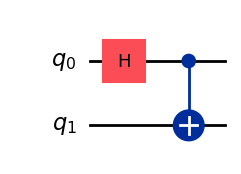

In [23]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import EstimatorV2 as Estimator
 
qc = QuantumCircuit(2)
 
qc.h(0)
 
qc.cx(0, 1)

qc.draw("mpl")

Esta parte del codigo define los observables, junto con etiquetas, esos relacionados a diferentes Qubits, se quiere medir propiedades específicas del estado cuántico, como lo son las correlaciones entre qubits.

In [24]:
observables_labels = ["IZ", "IX", "ZI", "XI", "ZZ", "XX"]
observables = [SparsePauliOp(label) for label in observables_labels]

#### B. Explicando el Paso 2

Aqui ya usamos el servicio de IBM Quantum para seleccionar el backend más adecuado, y pues, se quiere optimizar el circuito cuántico creado en el paso anterior y genera una versión optimizada del circuito,con tal de que este adaptado al backend, está se llama isa_circuit. Al puntos puntos importantes:
- service y backend: variables para conectarnos tanto con la api y contenedor en IBM
- pm: usa pass_manager para plantear ciertas reglas y poder optimizar el circuito y se divide en niveles, este es nivel 1, es decir crea una optimizacion basica.


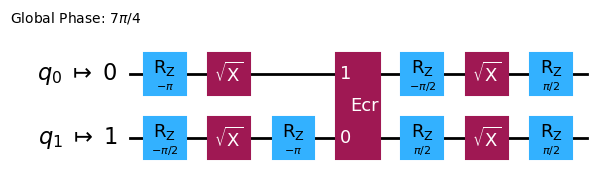

In [25]:
from qiskit_ibm_runtime import QiskitRuntimeService
 
service = QiskitRuntimeService()
 
backend = service.least_busy(simulator=False, operational=True)
 
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(qc)
 
isa_circuit.draw("mpl", idle_wires=False)

#### C. Explicando el Paso 3

Aqui, lo que se hace es configurar el estimador para calcular los valores esperados de los observables definidos anteriormente, despues de ello adaptar los observables al circuito optimizado, enviar el trabajo al backend y mostrar los resultados en consola o por matplot.
- Opciones del estimador: se define niveles para mejorar los errores, en esta caso es nivel 1, e indicmos que se ejecute el circuito un toal de 5000 veces.
- mapeo de observables: Se mapea porque puede existir una reorganizacion de qubits y deben alinearse a los osbervables.
- job: se envia el trabajo al backend(circuito optimizado y observables), para verificar esto, los rastreamos con el ID.

In [26]:
estimator = Estimator(mode=backend)
estimator.options.resilience_level = 1
estimator.options.default_shots = 5000
 
mapped_observables = [
    observable.apply_layout(isa_circuit.layout) for observable in observables
]
 
job = estimator.run([(isa_circuit, mapped_observables)])
 
print(f">>> Job ID: {job.job_id()}")

>>> Job ID: cxmz5angcckg008szck0


Aca, solamente recuperamos los resultados que nos da el backend y se accede al primer conjunto del trabajo.

In [27]:
job_result = job.result()
pub_result = job.result()[0]

#### D. Explicando el Paso 4

Esta parte, sirve para visualizar los resultados, donde cada oberbcvable tendra un reusltado esperado, por ejemplo:
- Si el valor de un observable es cercanp a 1 o -1, hay una correlación muy fuerte.
- Si es cercano a 0, la correlación es débil.
- Al generar el grafico, los obsrvables XX y ZZ, tienen una correlacion fuerte, los otros no.

Esto indica que los qubits están entrelazados y que las correlaciones fuertes en XX y ZZ son consistentes con un estado Bell.


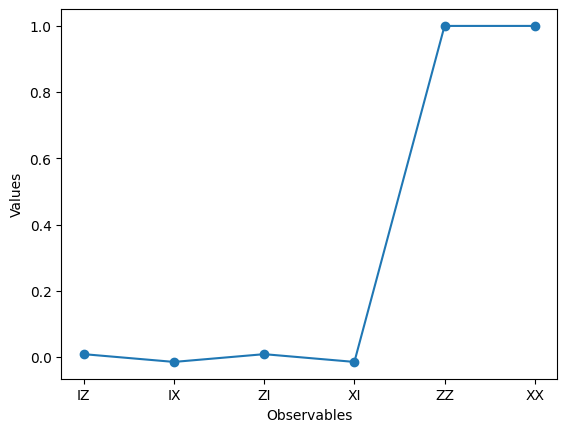

In [29]:
from matplotlib import pyplot as plt
 
values = pub_result.data.evs
 
errors = pub_result.data.stds

plt.plot(observables_labels, values, "-o")
plt.xlabel("Observables")
plt.ylabel("Values")
plt.show()

### 2. Escala de numeros de qubits

#### A. Explicando el Paso 1

En este segundo problema, lo que se quiere en esta parte del codigo es contruir un circuito en estado de GHZ con n-qubits
 - El circuito tiene 1 entrada "n",  el cual debe ser mayor o igual a 2
 - Al recibir la entrada, crea un circuito con los n-qubits y aplica las puertas de Hadamard solo para el primer qubit y puerta CNOT para entrelzar el primer qubit con los demas, cabe decir que lo hace 1 por 1.

In [30]:
from qiskit import QuantumCircuit
 
 
def get_qc_for_n_qubit_GHZ_state(n: int) -> QuantumCircuit:
    
    if isinstance(n, int) and n >= 2:
        qc = QuantumCircuit(n)
        qc.h(0)
        for i in range(n - 1):
            qc.cx(i, i + 1)
    else:
        raise Exception("n is not a valid input")
    return qc

n = 100
qc = get_qc_for_n_qubit_GHZ_state(n)

Aqui, definimos la lista de operadores, con Pauli, y realizar las correlaciones posteriormente, a difernecias del anterior, aqui los definimo no de manera estatica debido a que se quiere es analizar como se correlacionan y validar el entrelazamiento.
 - Operator string, genera cadenas donde Z va asignado a un par de qubits e I funciona como la identidad.
 - Operators, hace la conversion de cadena a objetos matemáticos.
 - En este caso el valor esperado para n es 100

In [31]:
from qiskit.quantum_info import SparsePauliOp
 
operator_strings = [
    "Z" + "I" * i + "Z" + "I" * (n - 2 - i) for i in range(n - 1)
]
print(operator_strings)
print(len(operator_strings))
 
operators = [SparsePauliOp(operator) for operator in operator_strings]

['ZZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII

#### B. Explicando el Paso 2

Aqui viene la configuracion con el backend y se hace el proceso de optimizacion, el cual es un proceso similar al primer ejercicio(Paso 2), soloque aqui es que debemos pasarle un total de 100 qubits y trasilar el modelo GHZ para que sea compatible con el backend.



In [32]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService
 
service = QiskitRuntimeService()
 
backend = service.least_busy(
    simulator=False, operational=True, min_num_qubits=100
)
pm = generate_preset_pass_manager(optimization_level=1, backend=backend)
 
isa_circuit = pm.run(qc)
isa_operators_list = [op.apply_layout(isa_circuit.layout) for op in operators]

#### C. Explicando el Paso 3

Aqui, configuramos las opciones del estimador cuántico para mejorar la calidad de las mediciones, y luego ejecutar el circuito cuántico sobre el backend.
Configuracion de Opciones:
- El nivel de resiliencia es de 1, indicando que queremos evitar que no se atan exhaustivo; 
- Se usa un acoplamiento dinamico que mejora el lado de la fidelidad y mitigacion de errores
- Se usa la secuencia XY4, que aplica pulsos alternados en ejer de X y Y para desacoplar los qubits.
- estimator: recibe la configuraciond e opciones y el backend.

In [33]:
from qiskit_ibm_runtime import EstimatorOptions
from qiskit_ibm_runtime import EstimatorV2 as Estimator
 
options = EstimatorOptions()
options.resilience_level = 1
options.dynamical_decoupling.enable = True
options.dynamical_decoupling.sequence_type = "XY4"
 
estimator = Estimator(backend, options=options)

Job representa como se esta dando la ejecucion en el circuito con el backend, mas que todo es para obtener un seguimiento.

In [34]:
job = estimator.run([(isa_circuit, isa_operators_list)])
job_id = job.job_id()
print(job_id)

cxmz9f5fdnwg008sxwj0


#### D. Explicando el Paso 4

En esta parte se visualizan los datos, lo que se quiere mostrar es:
 - Como varían las correlaciones entre los qubits en el estado GHZ de 100 qubits a medida que la distancia entre ellas va aumentando.
 - Mientras mas distancia se tenga, la correlacion disminuye. Esto se be al ruido que afectan a los qubits mas alejados.
 - GHZ a pesar de geenrar un entrelazamiento fuerte en los qubits, no esta libre de fallos, y visualizarlo permite ver esa distribucion.
 


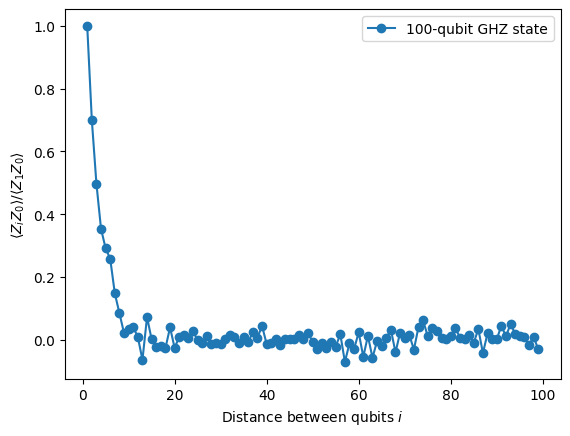

In [35]:
import matplotlib.pyplot as plt
from qiskit_ibm_runtime import QiskitRuntimeService
 

data = list(range(1, len(operators) + 1)) 
result = job.result()[0]
values = result.data.evs  
values = [
    v / values[0] for v in values
]  
 
plt.plot(data, values, marker="o", label="100-qubit GHZ state")
plt.xlabel("Distance between qubits $i$")
plt.ylabel(r"$\langle Z_i Z_0 \rangle / \langle Z_1 Z_0 \rangle $")
plt.legend()
plt.show()